# **Batch Process Data Alignment Algorithms**

Use of chemometric algorithms requires that batch process data be first aligned, so as to obtain a square tridimensional matrix. Examples of three batch process data alignment algorithms are shown on this repository.

Reference: 
Arzac, I. I., Vallerio, M., Perez-Galvan, C., & Navarro-Brull, F. J. (2023). Industrial Data Science for Batch Reactor Monitoring and Fault Detection. In Machine Learning and Hybrid Modelling for Reaction Engineering (pp. 358–403). Royal Society of Chemistry. https://doi.org/10.1039/bk9781837670178-00358.

Credit for the dataset goes to Salvador Garcia Muñoz (2023), retrieved from https://github.com/salvadorgarciamunoz/pyphi.

#### **Import required packages and set figure style**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk',font_scale=1.5,rc={"lines.linewidth": 3})
sns.set_palette('mako')
plt.rcParams['text.usetex'] = True  # write label & legend in LaTex
from dtw import *
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline, interp1d 

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



#### **Retrieve and analyze the dataset**

In [2]:
# Open the xlsx files
bdata  = pd.read_excel('Batch Dryer Case Study.xlsx',sheet_name='Trajectories')

# Remove all the columns with missing values. Name the new variable sensor_data_df
sensor_data_df = bdata.dropna()

# Time not given, only index. Assume that sensor measurements were recorded at regular intervals of 1 min; then convert units to hours
sensor_data_df = sensor_data_df.copy()     # Create a copy of the DataFrame to avoid SettingWithCopyWarning
sensor_data_df['Time [h]'] = np.zeros(len(sensor_data_df))

for j in sensor_data_df['Batch number'].unique():
    temporary_df = sensor_data_df.loc[sensor_data_df['Batch number'] == j].reset_index(drop=True)
    sensor_data_df.loc[sensor_data_df['Batch number'] == j,'Time [h]'] = temporary_df.index / 60 

# Analyze data visually
sensor_data_df

Batch number          Phase  Tank level  Differential pressure  \
0         Batch 1  Deagglomerate       0.000                  0.648   
1         Batch 1  Deagglomerate       0.156                  1.028   
2         Batch 1  Deagglomerate       0.981                  1.218   
3         Batch 1  Deagglomerate       1.856                  1.262   
4         Batch 1  Deagglomerate       2.730                  1.332   
...           ...            ...         ...                    ...   
9264     Batch 71       Cooldown      56.971                 -0.857   
9265     Batch 71       Cooldown      56.971                 -0.880   
9266     Batch 71       Cooldown      56.971                 -0.904   
9267     Batch 71       Cooldown      56.971                 -0.917   
9268     Batch 71       Cooldown      56.971                 -0.918   

      Dryer pressure  Power                  Torque                 \
0            119.943                127.302                  8.010   
1             62.902                138.398                  8.010   
2             56.042                141.096                  8.010   
3             56.431                140.870                  8.010   
4             56.820                136.792                  8.010   
...              ...                    ...                    ...   
9264         756.503                 60.490                 48.010   
9265         791.951                 60.335                 48.012   
9266         769.646                 60.225                 48.015   
9267         783.566                 57.595                 48.018   
9268         777.113                  0.304                 -0.223   

      Agitator Speed         Jacket Temp SP         Jacket Temp PV         \
0                    39.515                100.000                 18.697   
1                    40.260                100.000                 38.654   
2                    37.370                100.000                 57.419   
3                    40.803                100.000                 74.791   
4                    35.893                 86.552                 89.337   
...                     ...                    ...                    ...   
9264                  2.958                  0.000                 14.764   
9265                  2.380                  0.000                 14.637   
9266                  2.006                  0.000                 14.523   
9267                  1.801                  0.000                 14.473   
9268                 -0.074                 82.160                 14.775   

      Dryer Temp SP  Dryer Temp  Time [h]  
0            20.000      19.614  0.000000  
1            41.161      20.247  0.016667  
2            57.394      22.018  0.033333  
3            76.874      21.520  0.050000  
4            85.059      21.886  0.066667  
...             ...         ...       ...  
9264          4.073      48.091  1.700000  
9265          4.076      46.018  1.716667  
9266          4.080      43.681  1.733333  
9267          4.083      41.310  1.750000  
9268         25.000      38.937  1.766667  

[9227 rows x 13 columns]

#### **Plot the unaligned process variable trajectories**

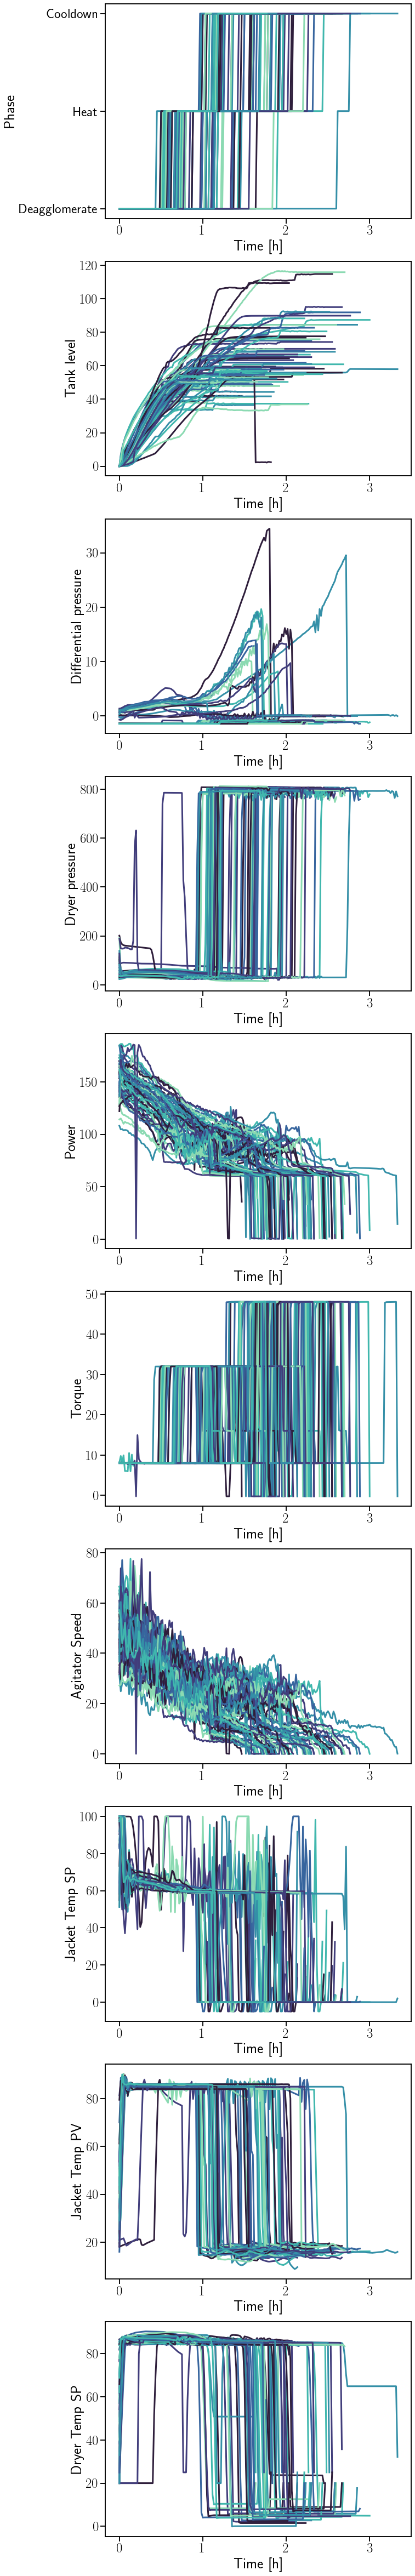

In [3]:
variables = sensor_data_df.columns[1:-2]    # Plot every variable except the batch number and the batch time

def PlotUnalignedTrajectories():
    fig, ax = plt.subplots(len(variables),1,figsize=(10,85))
    for j in range(len(variables)):
        variable = variables[j]
        ax[j].set_ylabel(variable)
        ax[j].set_xlabel('Time [h]')
        #ax[j].legend(str(sensor_data_df['Batch number'].unique()))
        for i in sensor_data_df['Batch number'].unique(): 
            ax[j].plot(sensor_data_df.loc[(sensor_data_df['Batch number'] == i),'Time [h]'],sensor_data_df.loc[(sensor_data_df['Batch number'] == i),variable])

PlotUnalignedTrajectories()

## **Batch data alignment** 

## <span style="color:blue"> A) Alignment by <strong>Automation Triggers</span>

<div class="alert alert-block alert-info">
<b> Automation triggers are activated in changes between stages</b>, e.g. the closure of the valve feeding the tank when changing stage from <i>Deagglomerate</i> to <i>Heat</i>. <br><br>The alignment thus aligns per stage and linearly interpolates within, on this case on a [0,1] range per stage.
</div>

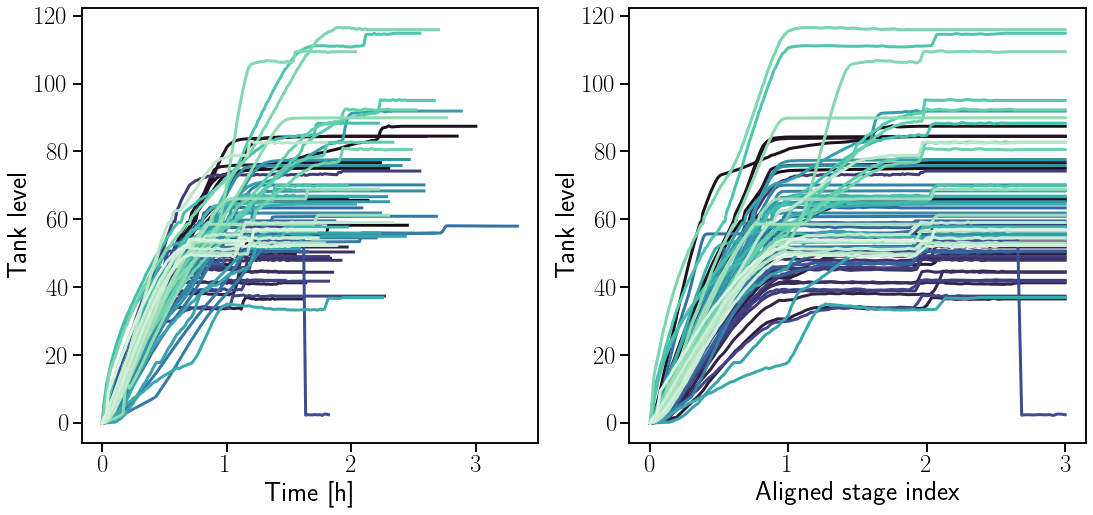

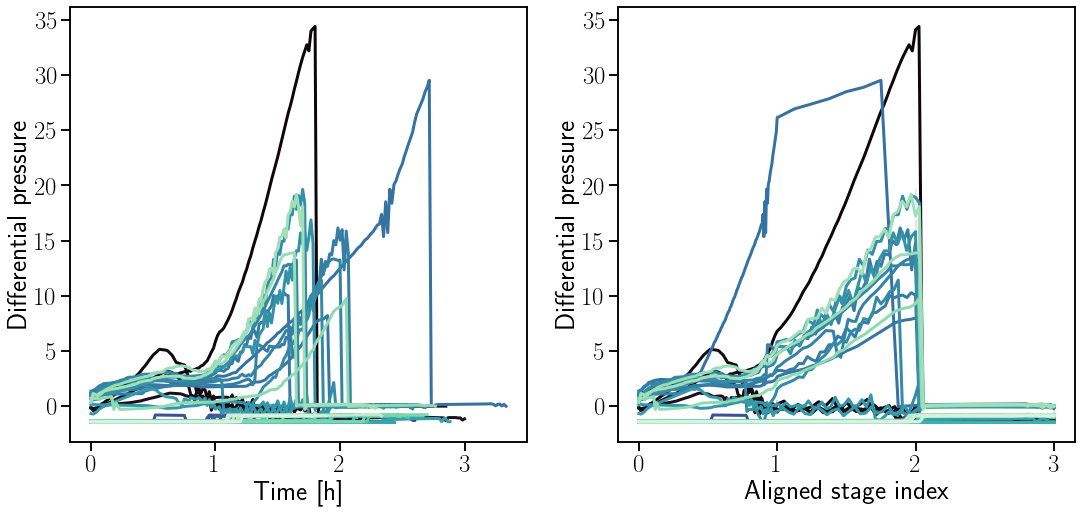

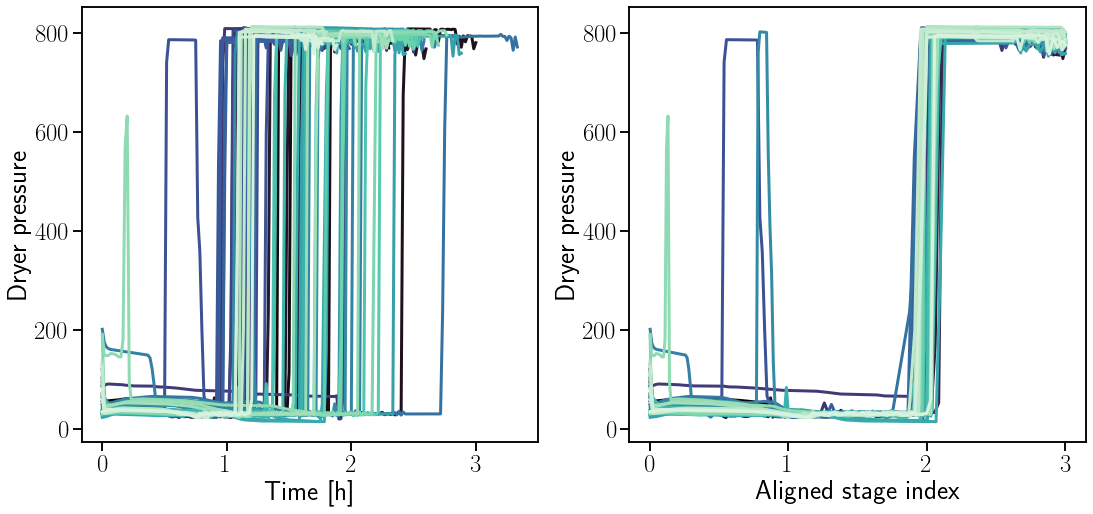

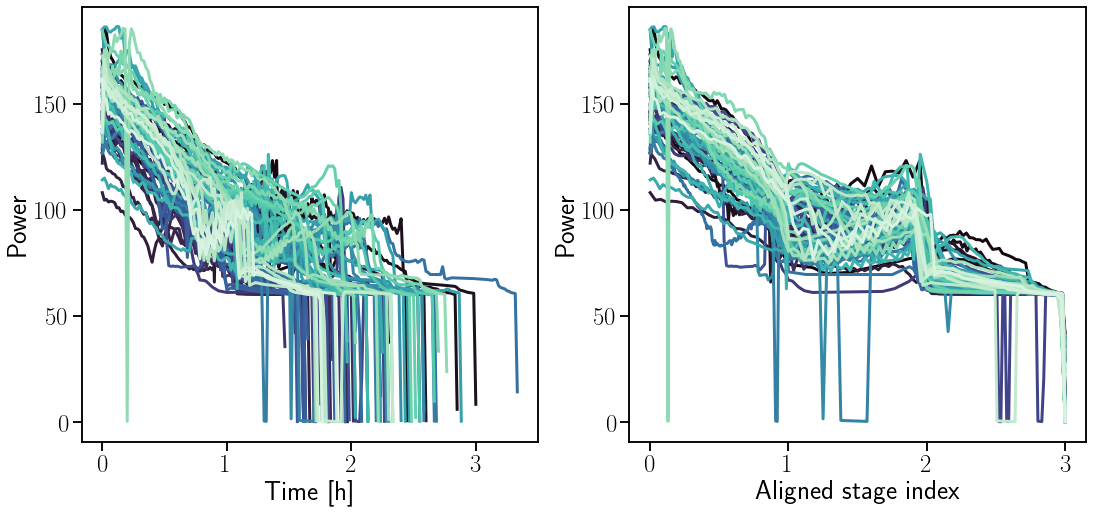

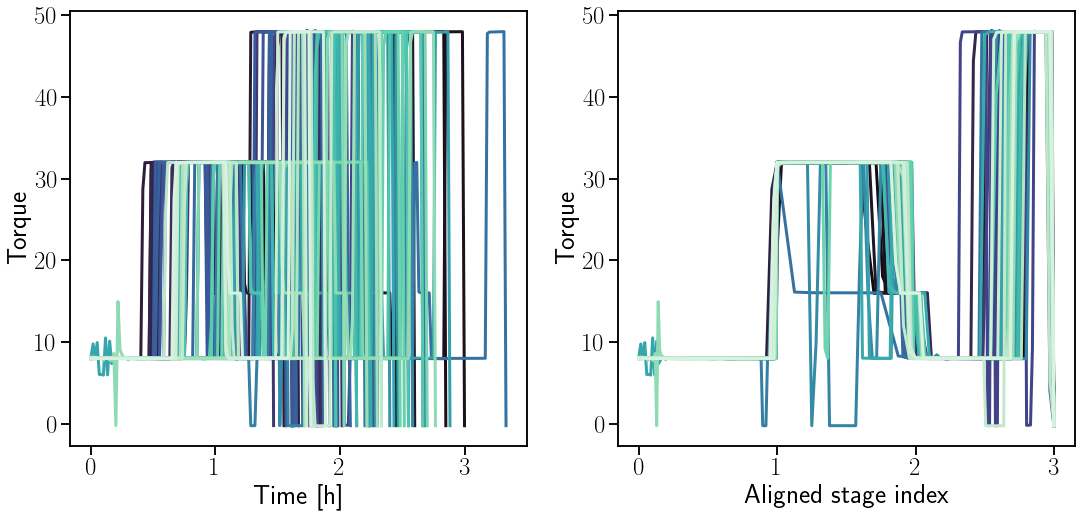

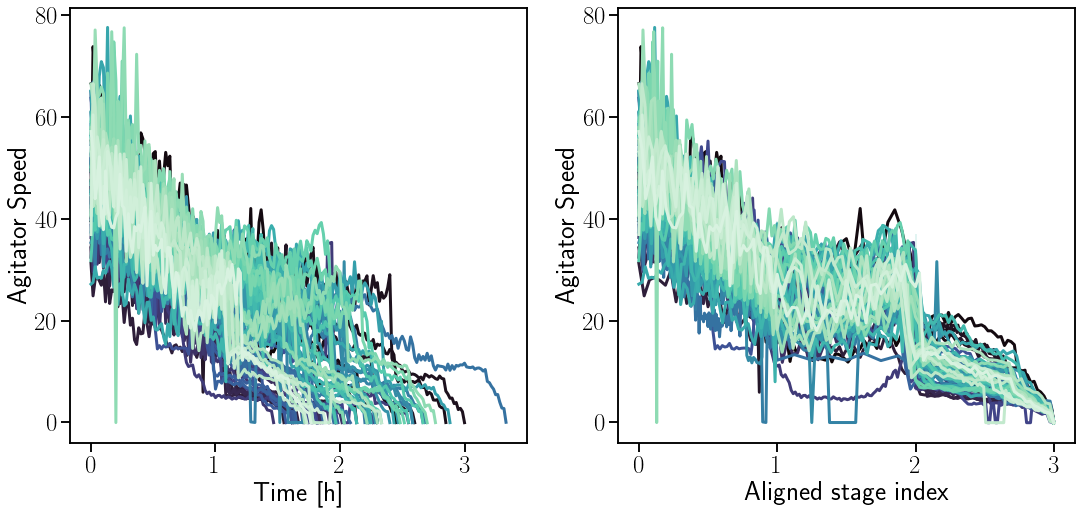

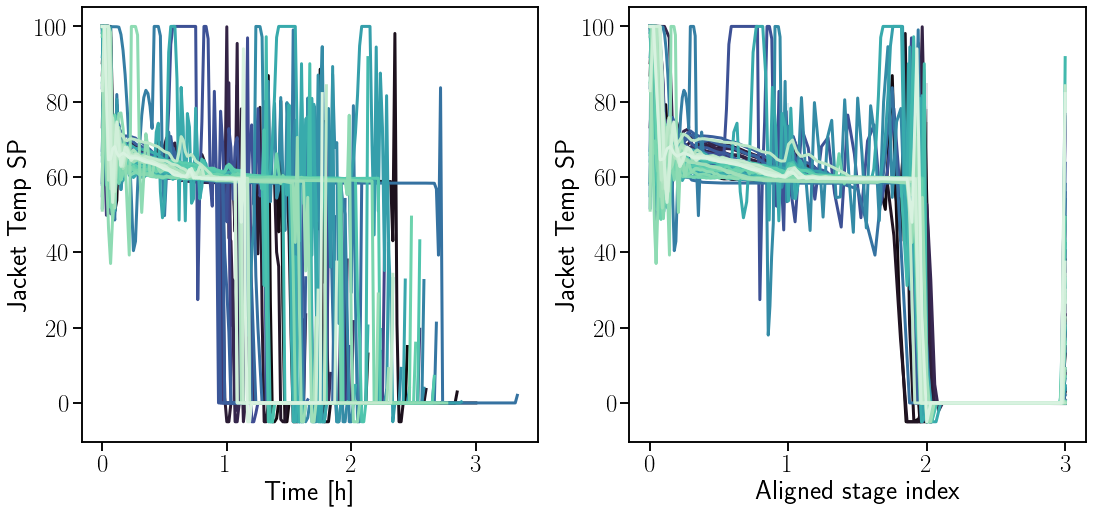

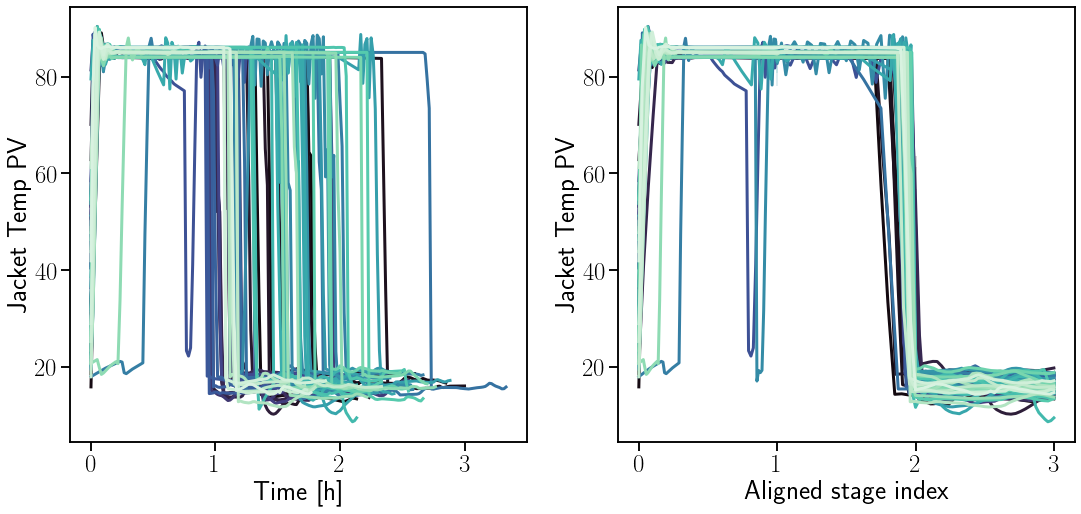

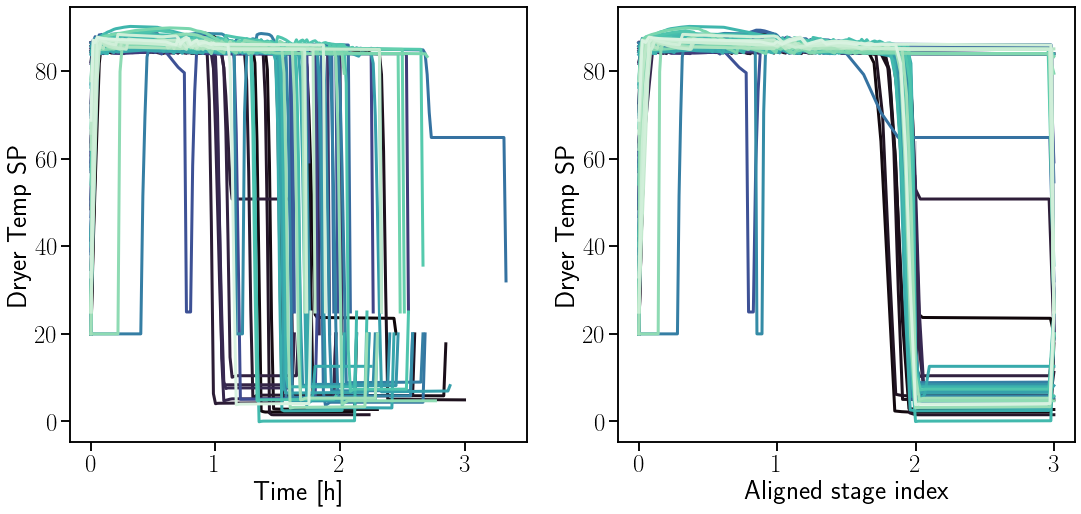

In [10]:
sensor_data_df['Phase'].unique()  # There are three stages in this batch process, namely Deagglomerate, Heat and Cooldown

sensor_data_df['Aligned stage index'] = np.zeros(len(sensor_data_df))

for j in sensor_data_df['Batch number'].unique():
    stage = 0
    for k in sensor_data_df['Phase'].unique():
        stage_time = sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == k),'Time [h]']
        sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == k),'Aligned stage index'] = stage + (stage_time-min(stage_time))/(max(stage_time)-min(stage_time))   # linearly interpolate time from stage beginning to end
        stage += 1    # next aligned stage will start 1 unit later

for i in variables[1:]:
    fig_var, ax_var = plt.subplots(1,2, figsize=(18,8))
    a = sns.lineplot(data=sensor_data_df,x='Time [h]',y=i,hue='Batch number',ax=ax_var[0],legend=False, palette='mako')
    b = sns.lineplot(data=sensor_data_df,x='Aligned stage index',y=i,hue='Batch number',ax=ax_var[1],legend=False, palette='mako')

<div class="alert alert-block alert-warning">
If the aim of the batch data alignment is to apply some chemometric algorithm (e.g. PCA, PLS, etc.), then each stage needs to consist of an equal number of data points across batch runs.
</div>

In [5]:
# Define the number of desired data points per stage
desired_data_points = 30  # Adjust this value as needed. Value should be high enough such that features of the process variable curves are not lost with the linear interpolation

# Create a new DataFrame to store the interpolated data
interpolated_sensor_data = pd.DataFrame()

# Iterate over unique batch numbers
for batch_number in sensor_data_df['Batch number'].unique():
    batch_data = sensor_data_df[sensor_data_df['Batch number'] == batch_number]
    
    # Iterate over unique stages
    stage_begin = 0 
    for stage in batch_data['Phase'].unique():
        stage_data = batch_data[batch_data['Phase'] == stage].copy()

        # Interpolate to achieve the desired number of data points
        interpolated_stage_data = pd.DataFrame()
        interpolated_stage_data['Aligned stage index'] = np.linspace(stage_begin, stage_begin+1, desired_data_points)
        for column in batch_data.columns:
            if column not in ['Batch number', 'Phase', 'Aligned stage index', 'Time [h]']:
                # Convert the column to numeric type before interpolation
                stage_data[column] = pd.to_numeric(stage_data[column], errors='coerce')
                interpolated_stage_data[column] = np.interp(
                    interpolated_stage_data['Aligned stage index'],
                    stage_data['Aligned stage index'],
                    stage_data[column]
                )
        
        # Add 'Batch number', 'Phase', and 'Time [h]' columns
        interpolated_stage_data['Batch number'] = batch_number
        interpolated_stage_data['Phase'] = stage
        interpolated_stage_data['Time [h]'] = np.interp(
            interpolated_stage_data['Aligned stage index'],
            stage_data['Aligned stage index'],
            stage_data['Time [h]']
        )
        
        interpolated_sensor_data = pd.concat([interpolated_sensor_data, interpolated_stage_data], ignore_index=True)

        stage_begin += 1


# 'interpolated_sensor_data' now contains the interpolated data with an equal number of data points per stage for each batch number
interpolated_sensor_data

Aligned stage index  Tank level  Differential pressure  Dryer pressure  \
0                0.000000    0.000000               0.648000      119.943000   
1                0.034483    1.101690               1.224069       56.095655   
2                0.068966    2.971379               1.376690       56.927310   
3                0.103448    4.875414               1.558345       57.800345   
4                0.137931    7.166724               1.640310       59.005621   
...                   ...         ...                    ...             ...   
6385             2.862069   56.971000              -0.862793      787.026034   
6386             2.896552   56.971000              -0.865724      769.948793   
6387             2.931034   56.971000              -0.894069      778.875655   
6388             2.965517   56.971000              -0.914310      780.686000   
6389             3.000000   56.971000              -0.918000      777.113000   

      Power                  Torque                 Agitator Speed         \
0                127.302000               8.010000              39.515000   
1                141.064828               8.010000              37.843517   
2                137.002483               8.010000              36.918103   
3                135.129931               8.011000              39.911862   
4                132.939034               8.011000              36.465690   
...                     ...                    ...                    ...   
6385              60.709310              48.007517               3.234414   
6386              60.431207              48.010759               2.738759   
6387              60.270517              48.013759               2.160759   
6388              58.139138              48.017379               1.843414   
6389               0.304000              -0.223000              -0.074000   

      Jacket Temp SP         Jacket Temp PV         Dryer Temp SP  Dryer Temp  \
0                100.000000              18.697000      20.000000   19.614000   
1                100.000000              59.815138      60.080897   21.949310   
2                 77.405517              88.667483      85.653483   22.100621   
3                 64.961828              82.943483      86.707000   23.753138   
4                 63.014655              85.789862      86.175172   24.870828   
...                     ...                    ...            ...         ...   
6385               0.000000              14.921241       4.069690   49.611276   
6386               0.000000              14.715828       4.074138   47.304690   
6387               0.000000              14.570172       4.078345   44.648034   
6388               0.000000              14.483345       4.082379   41.800552   
6389              82.160000              14.775000      25.000000   38.937000   

     Batch number          Phase  Time [h]  
0         Batch 1  Deagglomerate  0.000000  
1         Batch 1  Deagglomerate  0.035632  
2         Batch 1  Deagglomerate  0.071264  
3         Batch 1  Deagglomerate  0.106897  
4         Batch 1  Deagglomerate  0.142529  
...           ...            ...       ...  
6385     Batch 71       Cooldown  1.686207  
6386     Batch 71       Cooldown  1.706322  
6387     Batch 71       Cooldown  1.726437  
6388     Batch 71       Cooldown  1.746552  
6389     Batch 71       Cooldown  1.766667  

[6390 rows x 14 columns]

<div class="alert alert-block alert-success">
Notice that the spacing between aligned stage index value is constant within each stage but varies between stages. This ensures that on later chemometric analysis longer stages are weighed heavier.

<br><br>
N.B. for the above the number of data points stored for each stage on 'interpolated_sensor_data' is the same. This will give equal weight to all stages on a three-way data chemometric analysis (e.g. MPCA or MPLS). If it desired to more heavily weight some stage, a larger number of data points may be interpolated and stored for this stage. This is the approach followed by Salvador Garcia Muñoz on his [pyphi library](https://github.com/salvadorgarciamunoz/pyphi).

<br><br>
Another possibility would be store interpolated data points per stage, relative to the ratio of median duration of the stages, so as to more heavily weight in our posterior analysis the fact that some stages last on average longer than others.
</div>

## <span style="color:blue"> B) Alignment based on <strong>Indicator Variable</span>

<div class="alert alert-block alert-info">
<b> Batch process data can be aligned by plotting the variable trajectories against a measured or inferred indicator variable which correlates with batch maturity or progress</b> (e.g. conversion). Such a variable has to be monotonically increasing or decreasing in time and show low noise levels, with the same start- and end-points across batches. 
<br><br>The variable trajectories have to be interpolated if they want to be plotted at equal intervals of the indicator variable, resulting in the same N time points per batch run. For batch processes with several automation steps a different indicator variable may be available per phase, in which case trajectory alignment is performed separately.
</div>

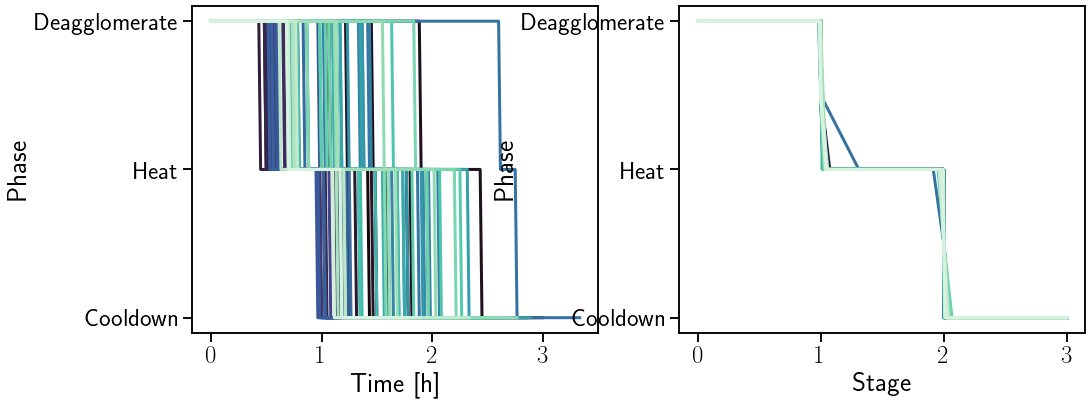

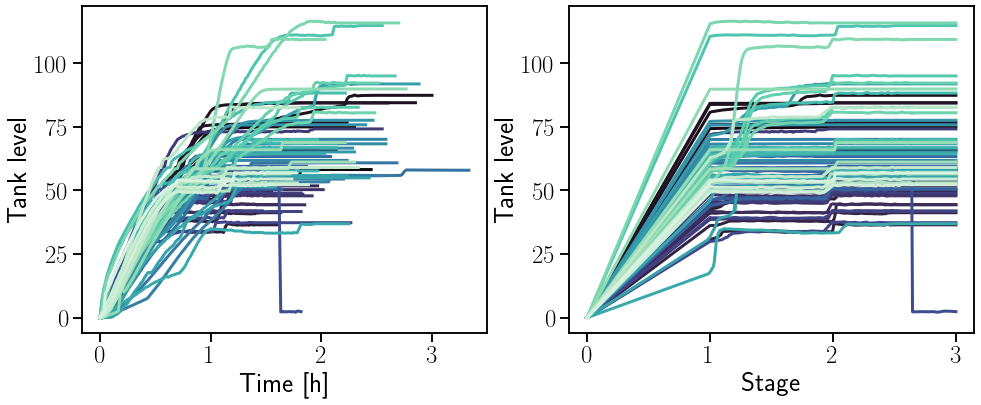

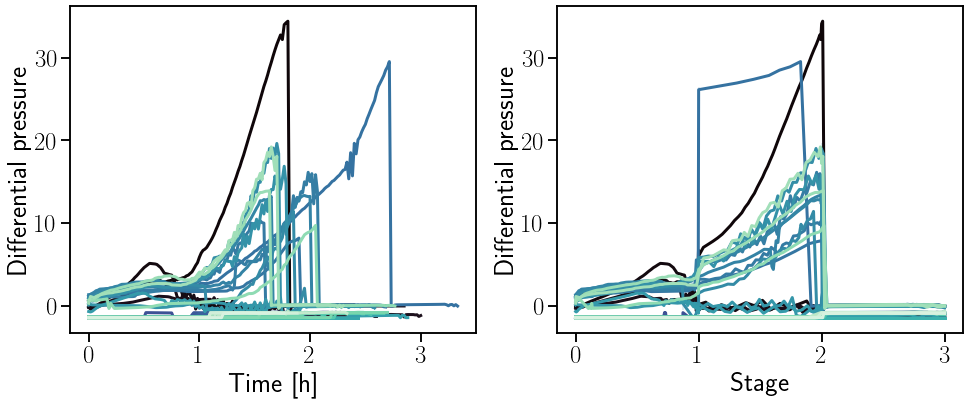

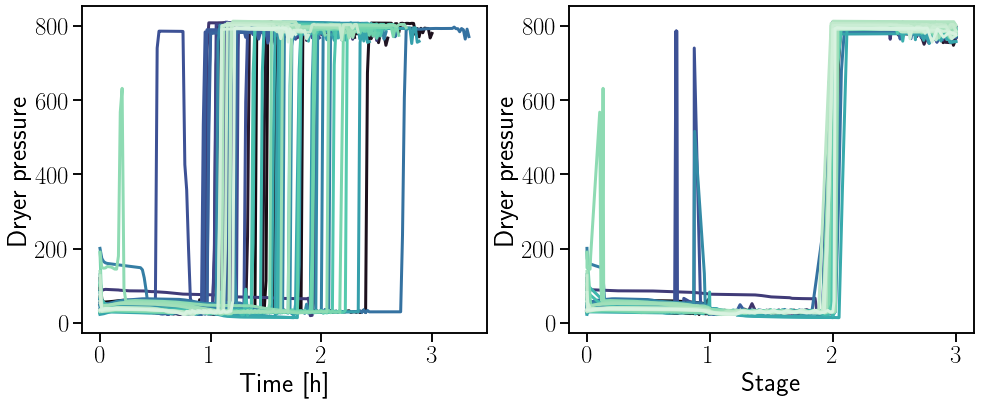

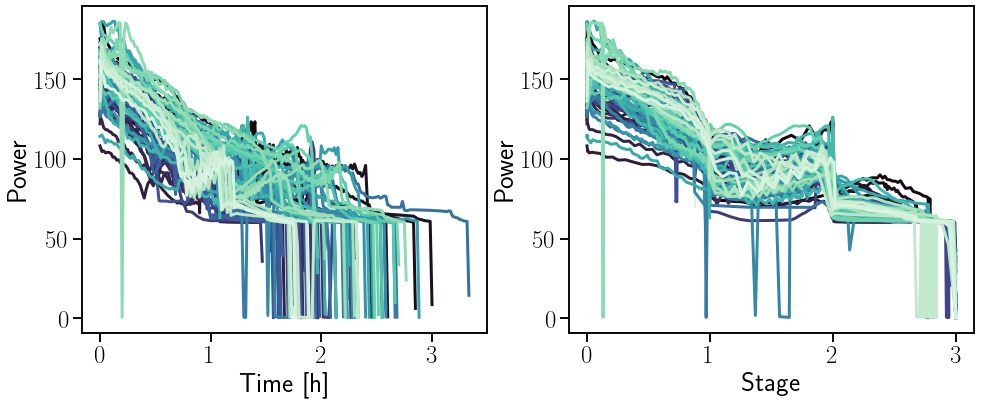

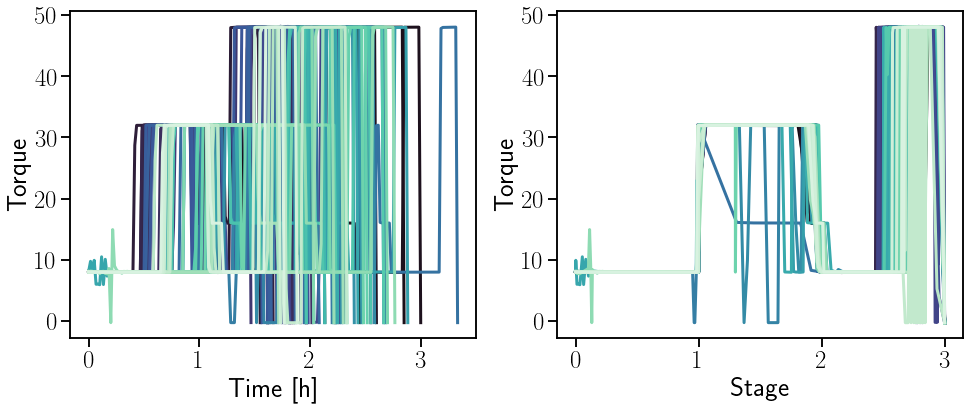

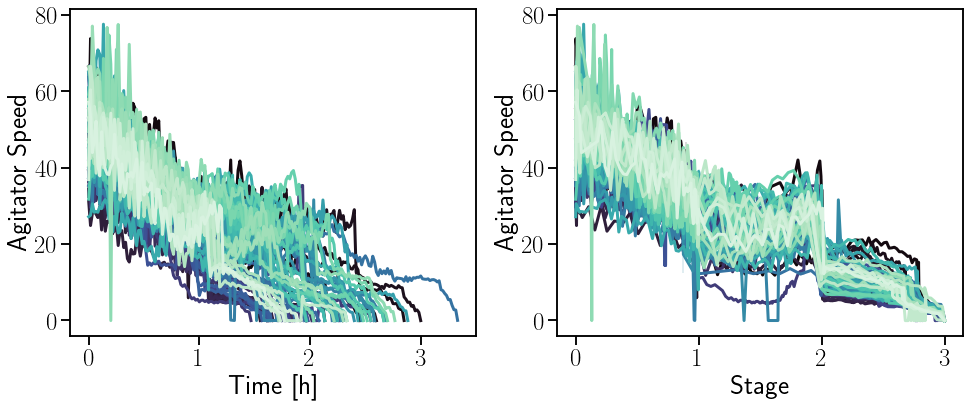

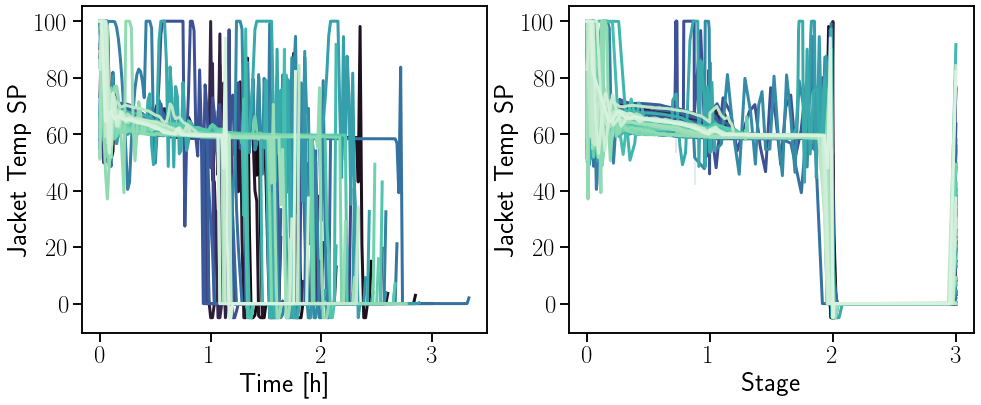

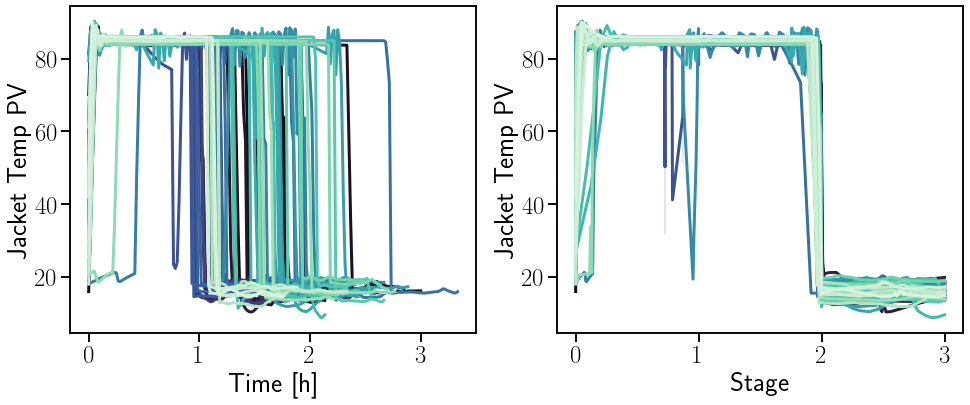

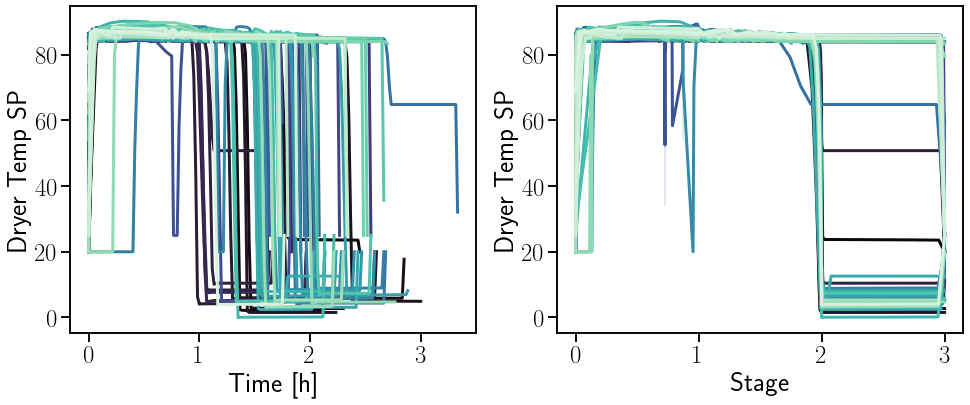

In [11]:
# Three indicator variables (one per stage). Each stage is assumed to account for 33.3% of the progress of the batch. Within this 1/3 of the x axis, plot variables w.r.t. indicator variable
sensor_data_df['Stage'] = np.zeros(len(sensor_data_df))
for j in sensor_data_df['Batch number'].unique():
    deagglomerate = sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Deagglomerate'),'Tank level']
    sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Deagglomerate'),'Stage'] = 0 + (deagglomerate-min(deagglomerate))/(max(deagglomerate)-min(deagglomerate))
    heat = sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Heat'),'Dryer Temp']
    sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Heat'),'Stage'] = 1 + (heat-min(heat))/(max(heat)-min(heat))
    cooldown = sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Cooldown'),'Dryer Temp']
    sensor_data_df.loc[(sensor_data_df['Batch number'] == j) & (sensor_data_df['Phase'] == 'Cooldown'),'Stage'] = 2 + (cooldown-max(cooldown))/(min(cooldown)-max(cooldown)) # susbtract max in the numerator since indicator variable is monotonically DECREASING on this stage

for i in variables:
    fig_var, ax_var = plt.subplots(1,2, figsize=(16,6))
    a = sns.lineplot(data=sensor_data_df,x='Time [h]',y=i,hue='Batch number',ax=ax_var[0],legend=False, palette='mako')t
    b = sns.lineplot(data=sensor_data_df,x='Stage',y=i,hue='Batch number',ax=ax_var[1],legend=False, palette='mako')

<div class="alert alert-block alert-warning">
Once again, if the aligned data will be used for PCA or PLS instead of just for visualization, an equal number of interpolated data points per stage is required across batches. The same code as was used for the automation trigger alignment can be used for this case.
</div>

## <span style="color:blue"> C) Alignment based on <strong>Dynamic Time Warping</span>

<div class="alert alert-block alert-info">
DTW searches for similar characteristics of two sets of variable trajectories based on a dynamic optimization scheme. <b>The trajectories are stretched and compressed so as to make them of equal length, while preserving the original data characteristics and aligning the landmark features.</b>

<br><br>
As opposed to the two previous algorithms, DTW requires the selection of a reference batch w.r.t. which the stretching of the signal is performed. The selected batch is typically the batch run with median duration among Normally Operating Condition batch runs. Notice below that the automation triggers do not necessarily align between batch runs. N.B.: these a simple showcase where all variables are asigned the same weight for warping. The algorithm can be tweaked to obtain a better alignment or to give a larger weight to some variable the process engineer finds of interest.
</div>



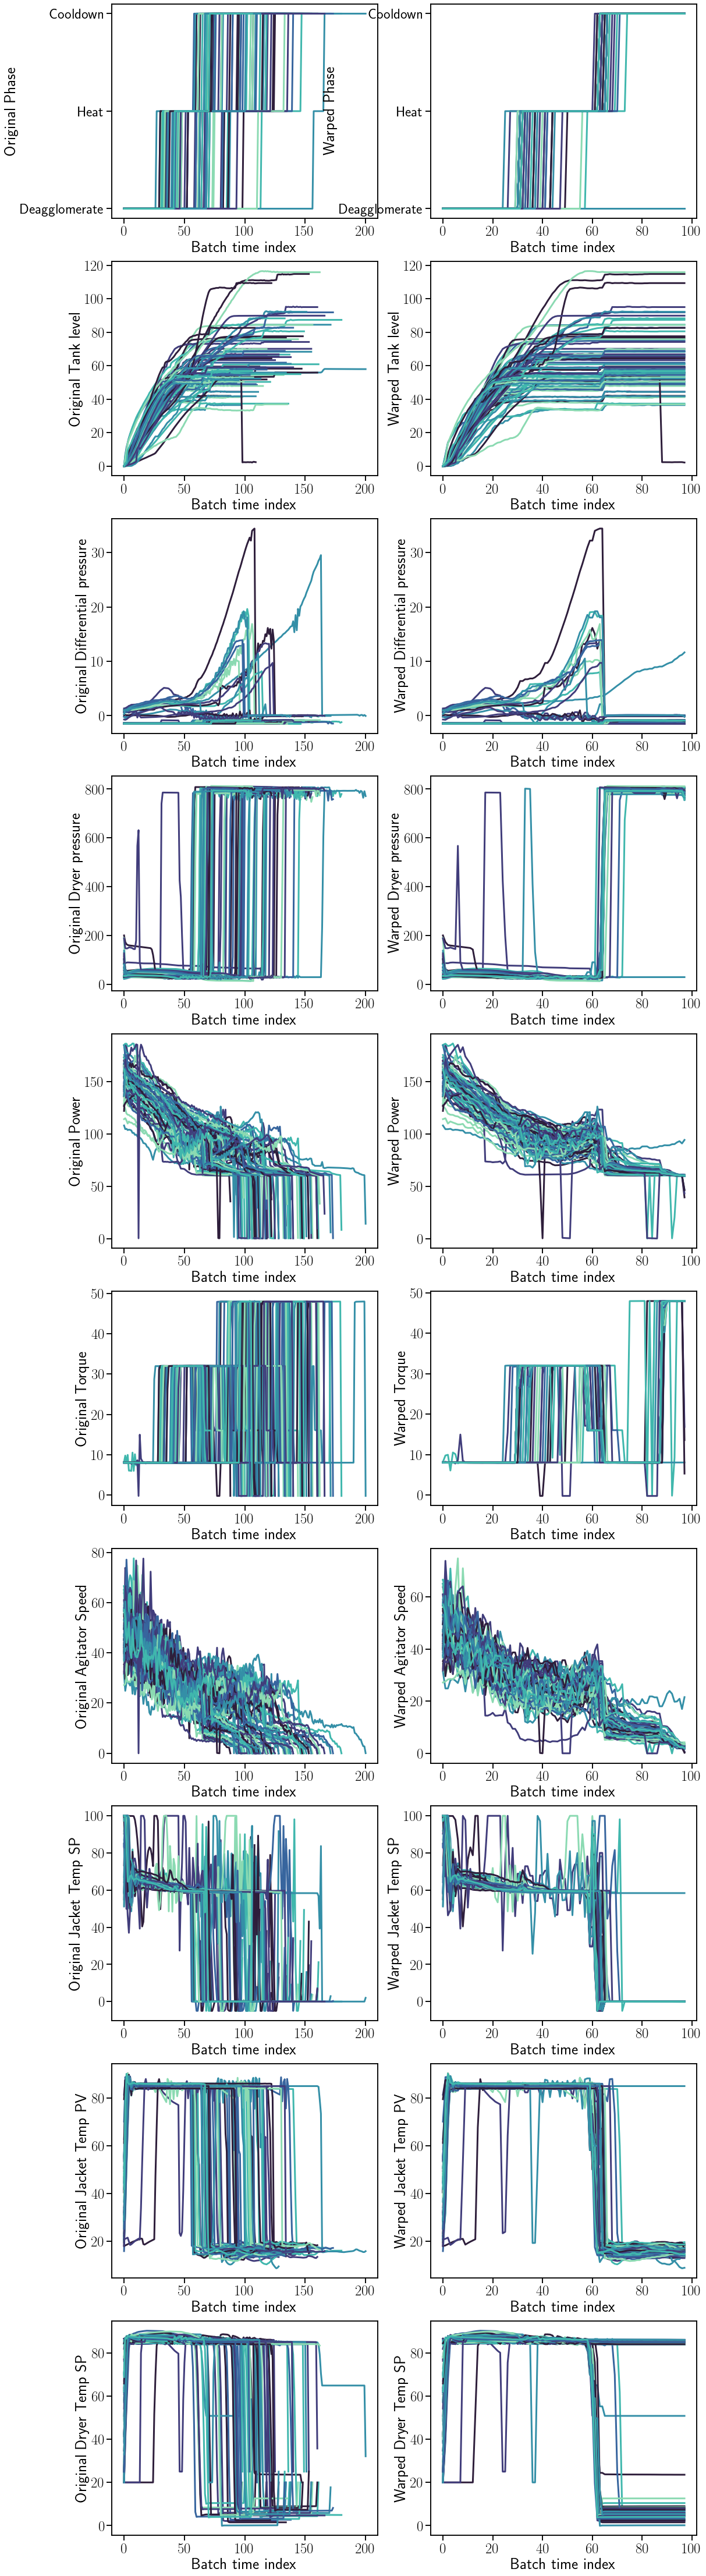

In [7]:
# Get batch run time for each 'Batch number'
batch_run_time = sensor_data_df.groupby('Batch number')['Time [h]'].last().tolist()

# Select batch with the median duration (time) as reference and warp the rest with respect to this one
median_runtime = np.median(batch_run_time)   # median runtime for all batch runs
median_duration_run = min(batch_run_time, key=lambda x:abs(x-median_runtime))  # duration of the batch closest to the median time (consider that with even number the median is calcualted as (n/2+(n/2+1))/2, so this number will be different than if the median_runtime is odd, i.e., (batch_durations % 2) == 0
median_index = batch_run_time.index(median_duration_run) + 1  # determine the index of the run with the median duration. Add 1 to account for the 0-indexing of Python (the first batch number will be 1)

from new_step_patterns import *

# Change the local constraint to symmetricP0, symmetricP05, symmetricP1, symmetricP2, ..., symmetricP10 and then run the function to obtain the graphs
def DTW_alignment_plot():
    fig, axes = plt.subplots(nrows=len(variables),ncols=2,figsize=(18,len(variables)*8))

    for i in sensor_data_df['Batch number'].unique():   # iterate over the batch runs

        # Multivariate classical DTW
        try:
            query_cDTW = sensor_data_df.loc[sensor_data_df['Batch number'] == i, variables[1:]].to_numpy()
            reference_cDTW = sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index), variables[1:]].to_numpy()   # extract the warping variable trajectory from the refrence data's batch number & the given stage number. Then convert to a numpy array to perform DTW
            alignment_cDTW = dtw(query_cDTW,reference_cDTW,keep_internals=True,open_end=False,step_pattern=symmetricP1,window_type=sakoeChibaWindow,window_args={'window_size': 100})   # First, perform a symmetric DTW with step_pattern='symmetric1', which favors diagonal steps
            wq_cDTW = warp(alignment_cDTW,index_reference=False)  # warp query. Set index_reference = False to warp the query instead of the reference. Multiple indices that would be mapped to a single point are averaged, with a warning. Gaps in the index sequence are filled by linear interpolation.
        except:
            pass
        
        for j, variable in enumerate(variables):
            # Plot the results
            axes[j,0].plot(range(len(sensor_data_df.loc[sensor_data_df['Batch number'] == i])),sensor_data_df.loc[sensor_data_df['Batch number'] == i,variable])   # unwarped query
            axes[j,1].plot(np.arange(len(wq_cDTW)),sensor_data_df.loc[sensor_data_df['Batch number'] == i,variable].reset_index(drop=True)[wq_cDTW])  # warped query
            axes[j, 0].set_xlabel('Batch time index'), axes[j, 0].set_ylabel(f'Original {variable}')
            axes[j, 1].set_xlabel('Batch time index'), axes[j, 1].set_ylabel(f'Warped {variable}')

DTW_alignment_plot()

<div class="alert alert-block alert-warning">
The classical DTW warps the signal based on its absolute value, which in some instances might cause undesired extreme time distorsion. This can be solved by applying DTW to the derivative of the signal, so as to align based on the signal's shape. This is referred to as Derivative DTW.
</div>

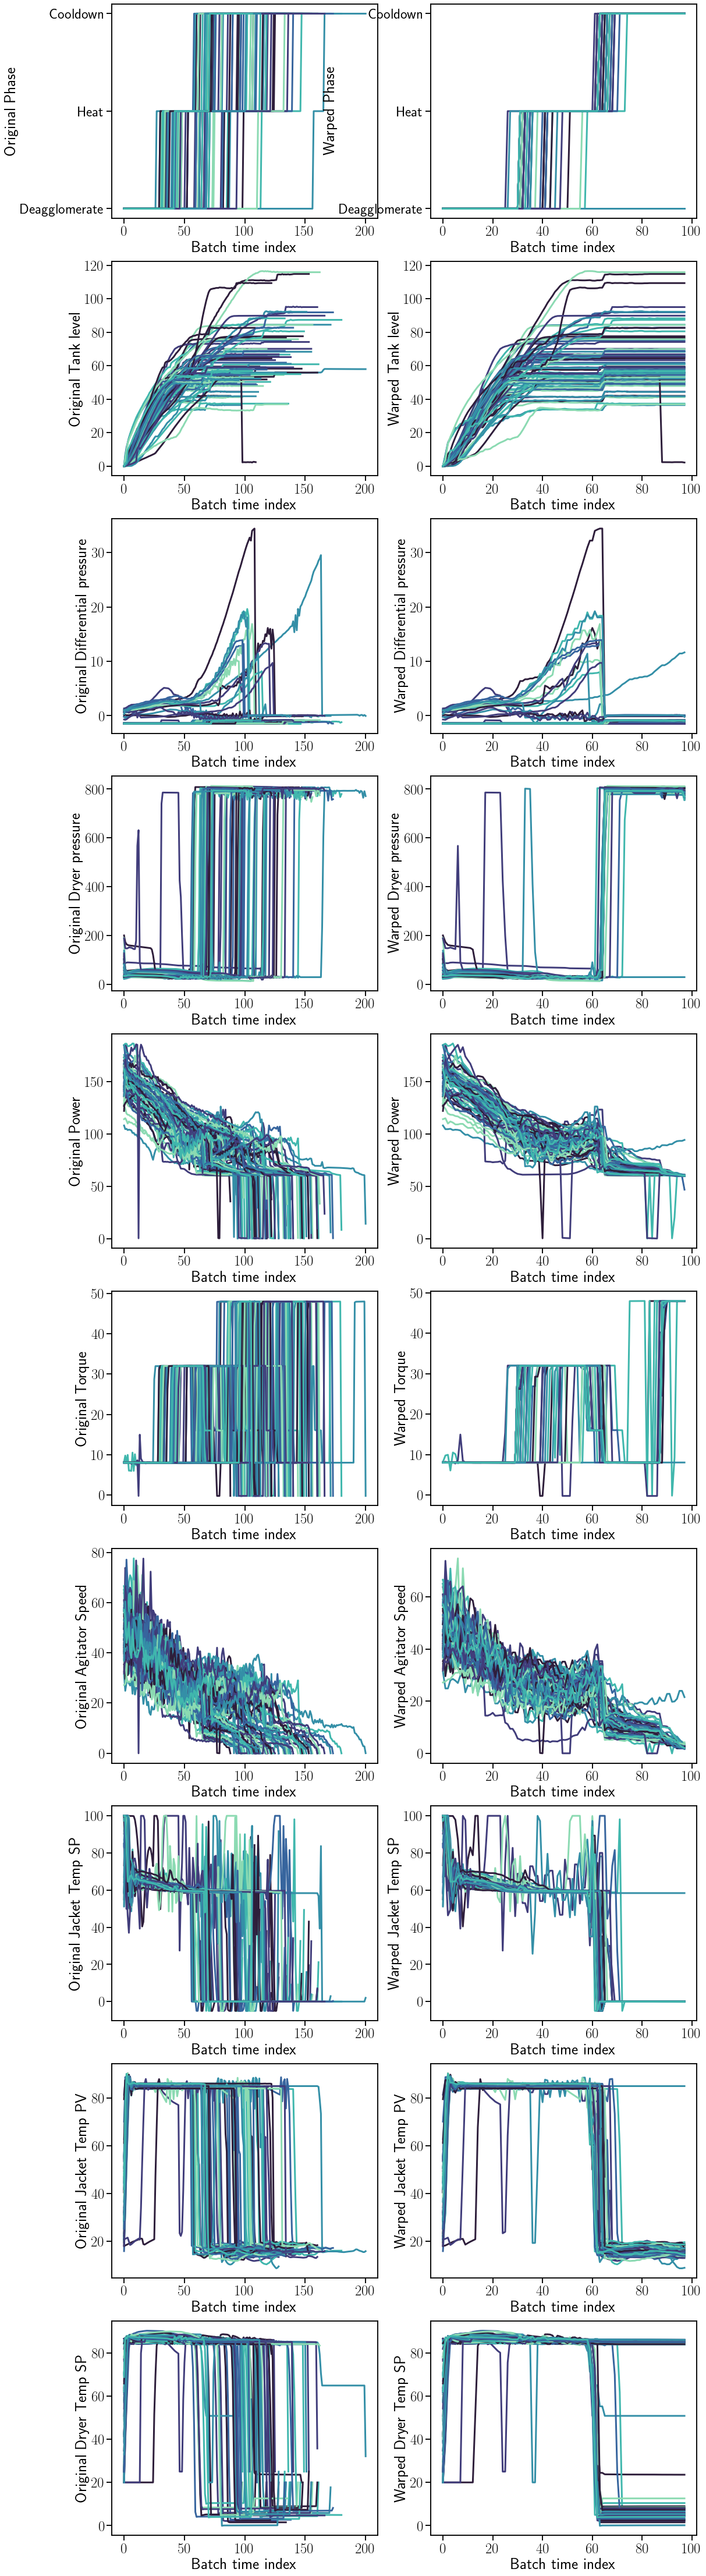

In [8]:
# Robust Derivative DTW
def RDDTW_alignment_plot():
    fig, axes = plt.subplots(nrows=len(variables),ncols=2,figsize=(18,len(variables)*8))

    delta_t = sensor_data_df.loc[sensor_data_df['Batch number']=='Batch '+str(median_index),'Time [h]'].iloc[1-0] # calculate the ∆t for the finite forward derivatives. Also consider that ∆t is the same as samples were measured every 120 s

    for i in sensor_data_df['Batch number'].unique():   # iterate over the batch runs
        for j, variable in enumerate(variables):
            try:
                # Multivariate robust derivative DTW
                query = sensor_data_df.loc[sensor_data_df['Batch number'] == i, variables[1:]].to_numpy()
                filtered_query = savgol_filter(query,window_length=7,polyorder=5)
                query_diff = np.diff(filtered_query)/delta_t
                reference = sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index), variables[1:]].to_numpy()  # extract the warping variable trajectory from the refrence data's batch number & the given stage number. Then convert to a numpy array to perform DTW
                filtered_reference = savgol_filter(reference,window_length=7,polyorder=5)
                reference_diff = np.diff(filtered_reference)/delta_t
                alignment_rdDTW = dtw(query_diff,reference_diff,keep_internals=True,open_end=False,step_pattern=symmetricP1,window_type=slantedBandWindow,window_args={'window_size': 100})   # First, perform a symmetric DTW with step_pattern='symmetric1', which favors diagonal steps
                wq_rdDTW = warp(alignment_rdDTW,index_reference=False)  # warp query. Set index_reference = False to warp the query instead of the reference. Multiple indices that would be mapped to a single point are averaged, with a warning. Gaps in the index sequence are filled by linear interpolation.
            except:
                pass 

            # Plot the results
            axes[j, 0].plot(range(len(sensor_data_df.loc[sensor_data_df['Batch number'] == i])),sensor_data_df.loc[sensor_data_df['Batch number'] == i,variable])   # unwarped query
            axes[j, 1].plot(np.arange(len(wq_rdDTW)),sensor_data_df.loc[sensor_data_df['Batch number'] == i,variable].reset_index(drop=True)[wq_rdDTW])  # warped query
            axes[j, 0].set_xlabel('Batch time index'), axes[j, 0].set_ylabel(f'Original {variable}')
            axes[j, 1].set_xlabel('Batch time index'), axes[j, 1].set_ylabel(f'Warped {variable}')


RDDTW_alignment_plot()

<div class="alert alert-block alert-success">
Another possibility to tweak the alignment is the selection of the local constraint P. At P=0, the most extreme warping of the time index will be allowed, whereas at P=abs(len(query)-len(reference)) a linear interpolation of the entire batch run will be performed. All P values in between consist of a combination of these two.
</div>

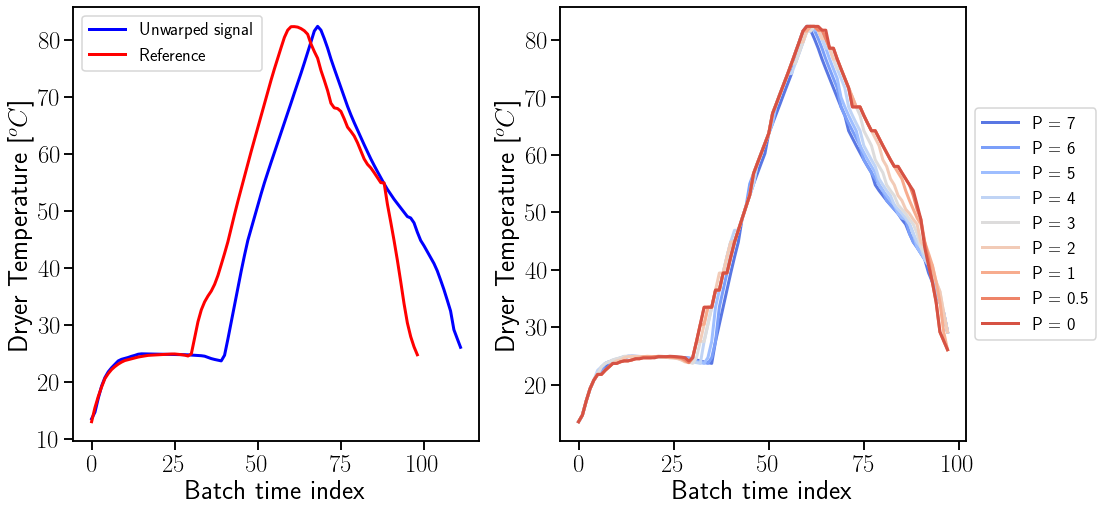

In [9]:
sns.set_palette("coolwarm",n_colors=9)

def effects_of_increasing_P():
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,8))
    for ax in axes:
        ax.set_xlabel('Batch time index'), ax.set_ylabel('Dryer Temperature [$^{o}C$]')

    # Univariate classical DTW
    query_cDTW = sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch 16', 'Dryer Temp'].to_numpy()
    reference_cDTW = sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch '+str(median_index), 'Dryer Temp'].to_numpy()   # extract the warping variable trajectory from the refrence data's batch number & the given stage number. Then convert to a numpy array to perform DTW

    for local_constraint_P in [symmetricP7,symmetricP6,symmetricP5,symmetricP4,symmetricP3,symmetricP2,symmetricP1,symmetricP05,symmetricP0]:   # iterate over the batch runs
        try:
            alignment_cDTW = dtw(query_cDTW,reference_cDTW,keep_internals=True,open_end=False,step_pattern=local_constraint_P,window_type=sakoeChibaWindow,window_args={'window_size': 100})   # First, perform a symmetric DTW with step_pattern='symmetric1', which favors diagonal steps
            wq_cDTW = warp(alignment_cDTW,index_reference=False)  # warp query. Set index_reference = False to warp the query instead of the reference. Multiple indices that would be mapped to a single point are averaged, with a warning. Gaps in the index sequence are filled by linear interpolation.

            # Plot the results
            axes[1].plot(np.arange(len(wq_cDTW)),sensor_data_df.loc[sensor_data_df['Batch number'] == 'Batch 16','Dryer Temp'].reset_index(drop=True)[wq_cDTW])  # warped query
            axes[1].legend(['P = 7','P = 6','P = 5','P = 4','P = 3','P = 2','P = 1','P = 0.5','P = 0'],loc='center left', bbox_to_anchor=(1, 0.5),prop={'size': 18})

        except:
            pass

    # Plot unwarped reference and query signals
    axes[0].plot(query_cDTW,color='blue')
    axes[0].plot(reference_cDTW,color='red')
    axes[0].legend(['Unwarped signal','Reference'],prop={'size': 18})

effects_of_increasing_P()